# Image Quality Analysis — Final Test

This notebook analyzes image quality metrics from the final user test (submission IDs 57-74, excluding 60).

**Analysis Plan:**
1. Load image data from database export and local image files
2. Calculate automated quality metrics (lighting, sharpness, contrast)
3. General descriptive analysis and visualizations
4. Test assumptions (normality, sample sizes)
5. Test two primary hypotheses comparing baseline to feedback conditions

**Hypotheses:**
$$H_{A1}: \text{Quality}_{P1} < \text{Quality}_{P2}$$
$$H_{A2}: \text{Quality}_{P1} < \text{Quality}_{P3}$$


Where P1 = Baseline, P2 = Post-Capture Feedback, P3 = Real-Time Feedback*Testing whether both feedback conditions (P2 and P3) independently improve image quality over baseline (P1).*


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load Data from Database Export

Load submission data, prototype assignments, and image metadata.

In [11]:
# Load all database export files
print('Loading database export files...')
print('='*80)

# Load submissions data
submissions = pd.read_csv('database_export/submissions_rows.csv')
print(f'✓ Loaded submissions: {len(submissions)} rows')

# Load and combine prototype data (split across 2 files)
proto_part1 = pd.read_csv('database_export/submission_prototype_rows_part1.csv')
proto_part2 = pd.read_csv('database_export/submission_prototype_rows_part2.csv')
prototypes = pd.concat([proto_part1, proto_part2], ignore_index=True)
print(f'✓ Loaded prototypes: {len(prototypes)} rows (part1: {len(proto_part1)}, part2: {len(proto_part2)})')

# Load and combine all images data files (split across 4 files)
images_1 = pd.read_csv('database_export/images_rows.csv')
images_2 = pd.read_csv('database_export/images_rows (1).csv')
images_3 = pd.read_csv('database_export/images_rows (2).csv')
images_4 = pd.read_csv('database_export/images_rows (3).csv')
images = pd.concat([images_1, images_2, images_3, images_4], ignore_index=True)
print(f'✓ Loaded images: {len(images)} rows (base: {len(images_1)}, file1: {len(images_2)}, file2: {len(images_3)}, file3: {len(images_4)})')

print(f'\nTotal rows loaded:')
print(f'  Submissions: {len(submissions)}')
print(f'  Prototypes: {len(prototypes)}')
print(f'  Images: {len(images)}')
print('='*80)

# Filter to allowed submission IDs (57-79 excluding 60)
allowed_ids = set(range(57, 80)) - {60}
submissions_filtered = submissions[submissions['id'].isin(allowed_ids)].copy()
prototypes_filtered = prototypes[prototypes['submission_id'].isin(allowed_ids)].copy()

# Join to get images with their prototype assignments
images_with_proto = images.merge(
    prototypes_filtered[['id', 'submission_id', 'prototype_name']], 
    left_on='submission_prototype_id', 
    right_on='id', 
    how='inner'
)

print(f'\nFiltered data (submission IDs 57-79, excluding 60):')
print(f'  Submissions: {len(submissions_filtered)}')
print(f'  Prototype sessions: {len(prototypes_filtered)}')
print(f'  Images: {len(images_with_proto)}')
print(f'\nImages per prototype:')
print(images_with_proto['prototype_name'].value_counts().sort_index())
print(f'\nFirst few rows:')
print(images_with_proto[['filename', 'prototype_name', 'submission_id']].head(10))

Loading database export files...
✓ Loaded submissions: 22 rows
✓ Loaded prototypes: 69 rows (part1: 31, part2: 38)
✓ Loaded images: 336 rows (base: 100, file1: 100, file2: 96, file3: 40)

Total rows loaded:
  Submissions: 22
  Prototypes: 69
  Images: 336

Filtered data (submission IDs 57-79, excluding 60):
  Submissions: 22
  Prototype sessions: 66
  Images: 186

Images per prototype:
prototype_name
Prototype 1    56
Prototype 2    64
Prototype 3    66
Name: count, dtype: int64

First few rows:
                         filename prototype_name  submission_id
0  1765218942635_Fossil1_p1_1.jpg    Prototype 1             57
1  1765218942635_Fossil1_p1_2.jpg    Prototype 1             57
2  1765218942635_Fossil1_p1_3.jpg    Prototype 1             57
3  1765218942635_Fossil1_p3_1.jpg    Prototype 3             57
4  1765218942635_Fossil1_p3_2.jpg    Prototype 3             57
5  1765218942635_Fossil1_p3_3.jpg    Prototype 3             57
6  1765218942635_Fossil1_p3_4.jpg    Prototype 3   

## 2. Calculate Image Quality Metrics

Define and apply automated quality metrics to all images.

In [12]:
# Image quality metric functions
def calculate_lighting_mean(image):
    """Average brightness (0-255)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return float(np.mean(gray))

def calculate_variance_of_laplacian(image):
    """Sharpness metric - higher values = sharper"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return float(laplacian.var())

def calculate_center_edge_contrast(image):
    """Contrast between center (object) and edge (background)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    center_y, center_x = height / 2, width / 2
    radius = min(height, width) * 0.3  # 60% diameter circle
    y_coords, x_coords = np.ogrid[:height, :width]
    distances = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    center_mask = distances < radius
    edge_mask = distances > (radius * 1.5)
    center_avg = float(np.mean(gray[center_mask]))
    edge_avg = float(np.mean(gray[edge_mask]))
    return abs(center_avg - edge_avg)

def analyze_image_quality(image_path):
    """Calculate all quality metrics for an image"""
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    return {
        'lighting_mean': round(calculate_lighting_mean(image), 2),
        'sharpness_metric': round(calculate_variance_of_laplacian(image), 2),
        'contrast_metric': round(calculate_center_edge_contrast(image), 2)
    }

print('Image quality functions defined')

Image quality functions defined


In [13]:
# Process all images directly from folder (database export incomplete)
# Prototype is inferred from filename pattern: _p1_, _p2_, _p3_
images_folder = Path('images')
results = []

print(f'Processing images from: {images_folder.absolute()}')
print('Inferring prototype from filename (_p1_, _p2_, _p3_)\n')

# Get all jpg images
image_files = list(images_folder.glob('*.jpg'))
print(f'Found {len(image_files)} JPG images')

for image_path in image_files:
    filename = image_path.name
    
    # Extract prototype from filename
    if '_p1_' in filename:
        prototype = 'Prototype 1'
    elif '_p2_' in filename:
        prototype = 'Prototype 2'
    elif '_p3_' in filename:
        prototype = 'Prototype 3'
    else:
        print(f'WARNING: Cannot determine prototype for {filename}')
        continue
    
    # Calculate metrics
    metrics = analyze_image_quality(image_path)
    
    if metrics is not None:
        results.append({
            'filename': filename,
            'prototype': prototype,
            **metrics
        })

# Create DataFrame
df_images = pd.DataFrame(results)

print(f'\n✓ Successfully analyzed {len(df_images)} images')
print(f'Dataset shape: {df_images.shape}')
print(f'\nImages per prototype:')
print(df_images['prototype'].value_counts().sort_index())
print(f'\nFirst few rows:')
print(df_images.head())

Processing images from: c:\Users\megan\Documents\GitHub\fossil-ai-feedback\results_analysis\final_test\images
Inferring prototype from filename (_p1_, _p2_, _p3_)

Found 183 JPG images

✓ Successfully analyzed 183 images
Dataset shape: (183, 5)

Images per prototype:
prototype
Prototype 1    55
Prototype 2    63
Prototype 3    65
Name: count, dtype: int64

First few rows:
                         filename    prototype  lighting_mean  \
0  1765218942635_Fossil1_p1_1.jpg  Prototype 1         125.19   
1  1765218942635_Fossil1_p1_2.jpg  Prototype 1         124.09   
2  1765218942635_Fossil1_p1_3.jpg  Prototype 1         121.62   
3  1765218942635_Fossil1_p2_1.jpg  Prototype 2         122.75   
4  1765218942635_Fossil1_p2_2.jpg  Prototype 2         117.55   

   sharpness_metric  contrast_metric  
0            210.00            69.89  
1            229.58            56.00  
2            206.80            74.66  
3            183.34            61.09  
4            182.67            87.79  


In [14]:
from pathlib import Path



# Preserve manual ratings if they already exist; otherwise create a template
output_csv = 'image_quality_with_manual_ratings.csv'
manual_path = Path(output_csv)

# Default to empty columns until we confirm manual ratings exist
if manual_path.exists():
    manual_df = pd.read_csv(manual_path)
    expected_cols = {'filename', 'prototype', 'lighting_mean', 'sharpness_metric', 'contrast_metric', 'scale_rating', 'angle_rating'}
    missing_cols = expected_cols - set(manual_df.columns)
    if missing_cols:
        # If any expected columns are missing, add them as empty so downstream merges do not fail
        for col in missing_cols:
            manual_df[col] = np.nan
    
    # Coerce manual ratings to numeric (Likert 1-5)
    manual_df['scale_rating'] = pd.to_numeric(manual_df['scale_rating'], errors='coerce')
    manual_df['angle_rating'] = pd.to_numeric(manual_df['angle_rating'], errors='coerce')

    # Merge manual ratings into current analysis dataframe
    df_images = df_images.merge(
        manual_df[['filename', 'scale_rating', 'angle_rating']],
        on='filename',
        how='left'
    )

    print(f'\n✓ Loaded manual ratings from: {output_csv}')
    print(f'Rows in manual file: {len(manual_df)} (analysis rows: {len(df_images)})')
    print(f'Scale ratings available: {df_images["scale_rating"].notna().sum()} of {len(df_images)}')
    print(f'Angle ratings available: {df_images["angle_rating"].notna().sum()} of {len(df_images)}')
else:
    # Create a fresh export template without overwriting any existing manual work
    df_export = df_images.copy()
    df_export['scale_rating'] = ''
    df_export['angle_rating'] = ''

    columns_order = ['filename', 'prototype', 'lighting_mean', 'sharpness_metric',
                     'contrast_metric', 'scale_rating', 'angle_rating']
    df_export = df_export[columns_order]

    df_export.to_csv(output_csv, index=False)
    df_images['scale_rating'] = np.nan
    df_images['angle_rating'] = np.nan

    print(f'\n⚠️ Manual ratings file not found; created template at: {output_csv}')
    print(f'Total rows: {len(df_export)}')
    print(f'Columns: {", ".join(df_export.columns)}')
    print('\nAdd scale_rating and angle_rating (1=very poor, 5=very good) before re-running analyses.')

print('\nFirst few rows (including manual ratings if present):')
print(df_images[['filename', 'prototype', 'lighting_mean', 'sharpness_metric',
                 'contrast_metric', 'scale_rating', 'angle_rating']].head(10))


✓ Loaded manual ratings from: image_quality_with_manual_ratings.csv
Rows in manual file: 183 (analysis rows: 183)
Scale ratings available: 183 of 183
Angle ratings available: 183 of 183

First few rows (including manual ratings if present):
                         filename    prototype  lighting_mean  \
0  1765218942635_Fossil1_p1_1.jpg  Prototype 1         125.19   
1  1765218942635_Fossil1_p1_2.jpg  Prototype 1         124.09   
2  1765218942635_Fossil1_p1_3.jpg  Prototype 1         121.62   
3  1765218942635_Fossil1_p2_1.jpg  Prototype 2         122.75   
4  1765218942635_Fossil1_p2_2.jpg  Prototype 2         117.55   
5  1765218942635_Fossil1_p2_3.jpg  Prototype 2         119.15   
6  1765218942635_Fossil1_p3_1.jpg  Prototype 3         124.14   
7  1765218942635_Fossil1_p3_2.jpg  Prototype 3         122.40   
8  1765218942635_Fossil1_p3_3.jpg  Prototype 3         123.35   
9  1765218942635_Fossil1_p3_4.jpg  Prototype 3         124.80   

   sharpness_metric  contrast_metric  scal

## 3. General Descriptive Analysis

Examine distributions and summary statistics across all prototypes.

In [15]:
# Overall statistics (all five image-quality metrics: 3 automated + 2 expert ratings)
metrics_all = ['lighting_mean', 'sharpness_metric', 'contrast_metric', 'scale_rating', 'angle_rating']

print('='*80)
print('OVERALL IMAGE QUALITY STATISTICS')
print('='*80)
print(df_images[metrics_all].describe().round(2))

# Statistics by prototype
print('\n' + '='*80)
print('STATISTICS BY PROTOTYPE')
print('='*80)

for proto in sorted(df_images['prototype'].unique()):
    proto_data = df_images[df_images['prototype'] == proto]
    print(f'\n{proto} (n={len(proto_data)}):')
    print(f'  Lighting:       {proto_data["lighting_mean"].mean():6.2f} ± {proto_data["lighting_mean"].std():.2f}')
    print(f'  Sharpness:      {proto_data["sharpness_metric"].mean():6.2f} ± {proto_data["sharpness_metric"].std():.2f}')
    print(f'  Contrast:       {proto_data["contrast_metric"].mean():6.2f} ± {proto_data["contrast_metric"].std():.2f}')
    print(f'  Scale rating:   {proto_data["scale_rating"].mean():6.2f} ± {proto_data["scale_rating"].std():.2f}')
    print(f'  Angles rating:  {proto_data["angle_rating"].mean():6.2f} ± {proto_data["angle_rating"].std():.2f}')


OVERALL IMAGE QUALITY STATISTICS
       lighting_mean  sharpness_metric  contrast_metric  scale_rating  \
count         183.00            183.00           183.00        183.00   
mean          143.73            242.42            33.41          4.28   
std            26.81            278.82            22.56          1.37   
min            10.27              5.14             0.30          1.00   
25%           124.48             67.47            14.78          4.00   
50%           145.18            169.71            31.85          5.00   
75%           162.94            320.68            48.93          5.00   
max           196.04           1984.98            99.48          5.00   

       angle_rating  
count        183.00  
mean           4.21  
std            0.98  
min            1.00  
25%            4.00  
50%            4.00  
75%            5.00  
max            5.00  

STATISTICS BY PROTOTYPE

Prototype 1 (n=55):
  Lighting:       141.84 ± 29.83
  Sharpness:      264.29 ± 349.0

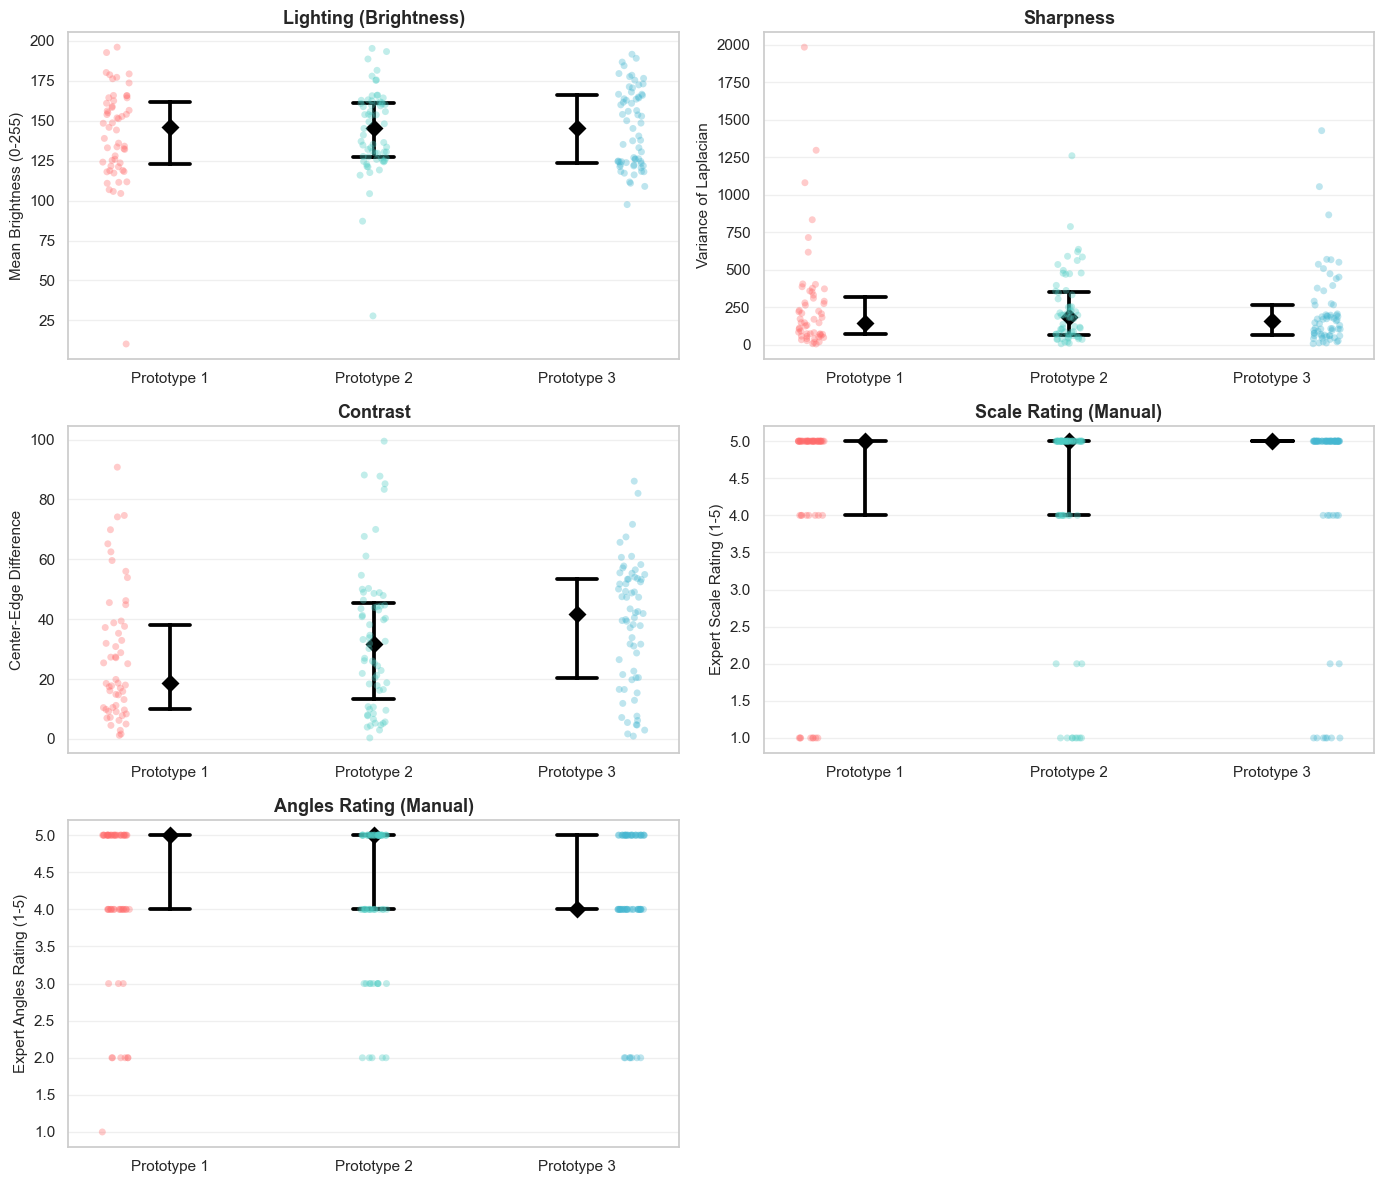

In [16]:
import math
import seaborn as sns

# More interpretable small-multiples: point + IQR ribbon + jittered points
metrics_info = [
    ('lighting_mean', 'Lighting (Brightness)', 'Mean Brightness (0-255)'),
    ('sharpness_metric', 'Sharpness', 'Variance of Laplacian'),
    ('contrast_metric', 'Contrast', 'Center-Edge Difference'),
    ('scale_rating', 'Scale Rating (Manual)', 'Expert Scale Rating (1-5)'),
    ('angle_rating', 'Angles Rating (Manual)', 'Expert Angles Rating (1-5)')
]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
prototypes = sorted(df_images['prototype'].unique())

# Long-form for seaborn
metric_labels = {m: title for m, title, _ in metrics_info}
df_plot = df_images.melt(
    id_vars=['prototype'],
    value_vars=[m for m, _, _ in metrics_info],
    var_name='metric',
    value_name='value'
)
df_plot['metric_label'] = df_plot['metric'].map(metric_labels)

n_metrics = len(metrics_info)
n_cols = 2
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
axes = axes.flatten()
sns.set_theme(style='whitegrid')

for idx, (metric, title, ylabel) in enumerate(metrics_info):
    ax = axes[idx]
    subset = df_plot[df_plot['metric'] == metric]
    
    # Jittered points for distribution
    sns.stripplot(
        data=subset,
        x='prototype',
        y='value',
        hue='prototype',
        dodge=True,
        jitter=0.2,
        alpha=0.35,
        palette=colors,
        ax=ax
    )
    
    # Median with IQR error bars
    sns.pointplot(
        data=subset,
        x='prototype',
        y='value',
        estimator=np.median,
        errorbar=('pi', 50),  # 25th-75th percentile interval
        join=False,
        capsize=0.2,
        markers='D',
        color='black',
        ax=ax
    )
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if leg:
        leg.remove()
    ax.grid(axis='y', alpha=0.3)

# Hide unused axes if any
for ax in axes[n_metrics:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## 4. Check Statistical Test Assumptions

Determine whether data meets requirements for parametric vs non-parametric tests.

In [17]:
from scipy.stats import shapiro, levene

print('='*80)
print('ASSUMPTION CHECKS FOR STATISTICAL TESTING')
print('='*80)

metrics = ['lighting_mean', 'sharpness_metric', 'contrast_metric']
prototypes = sorted(df_images['prototype'].unique())

# 1. Sample sizes
print('\n1. SAMPLE SIZES (n ≥ 20 recommended for parametric tests):')
print('-'*80)
for proto in prototypes:
    n = len(df_images[df_images['prototype'] == proto])
    print(f'{proto}: n = {n}')

# 2. Normality tests (Shapiro-Wilk)
print('\n2. NORMALITY TESTS (Shapiro-Wilk, p > 0.05 = normal):')
print('-'*80)
normality_results = {}

for metric in metrics:
    print(f'\n{metric}:')
    normal_count = 0
    for proto in prototypes:
        data = df_images[df_images['prototype'] == proto][metric].dropna()
        if len(data) >= 3:
            stat, p = shapiro(data)
            is_normal = p > 0.05
            normal_count += is_normal
            print(f'  {proto}: p = {p:.4f} {"✓ Normal" if is_normal else "✗ Not normal"}')
        else:
            print(f'  {proto}: insufficient data')
    normality_results[metric] = normal_count == len(prototypes)

# 3. Homogeneity of variance (Levene's test)
print('\n3. HOMOGENEITY OF VARIANCE (Levene test, p > 0.05 = equal variances):')
print('-'*80)
variance_results = {}

for metric in metrics:
    groups = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    groups = [g for g in groups if len(g) >= 2]
    
    if len(groups) >= 2:
        stat, p = levene(*groups)
        equal_var = p > 0.05
        variance_results[metric] = equal_var
        print(f'{metric}: p = {p:.4f} {"✓ Equal variances" if equal_var else "✗ Unequal variances"}')
    else:
        print(f'{metric}: insufficient data')
        variance_results[metric] = False

# 4. Decision
print('\n' + '='*80)
print('RECOMMENDATION:')
print('='*80)

use_parametric = all(normality_results.values()) and all(variance_results.values())

if use_parametric:
    print('✓ All assumptions met → Use PARAMETRIC tests (one-way ANOVA)')
else:
    print('✗ Assumptions violated → Use NON-PARAMETRIC tests (Kruskal-Wallis)')
    print('\nViolations:')
    if not all(normality_results.values()):
        non_normal = [m for m, v in normality_results.items() if not v]
        print(f'  - Normality: {", ".join(non_normal)}')
    if not all(variance_results.values()):
        unequal_var = [m for m, v in variance_results.items() if not v]
        print(f'  - Homogeneity: {", ".join(unequal_var)}')

print('\n' + '='*80)

ASSUMPTION CHECKS FOR STATISTICAL TESTING

1. SAMPLE SIZES (n ≥ 20 recommended for parametric tests):
--------------------------------------------------------------------------------
Prototype 1: n = 55
Prototype 2: n = 63
Prototype 3: n = 65

2. NORMALITY TESTS (Shapiro-Wilk, p > 0.05 = normal):
--------------------------------------------------------------------------------

lighting_mean:
  Prototype 1: p = 0.0002 ✗ Not normal
  Prototype 2: p = 0.0002 ✗ Not normal
  Prototype 3: p = 0.0020 ✗ Not normal

sharpness_metric:
  Prototype 1: p = 0.0000 ✗ Not normal
  Prototype 2: p = 0.0000 ✗ Not normal
  Prototype 3: p = 0.0000 ✗ Not normal

contrast_metric:
  Prototype 1: p = 0.0002 ✗ Not normal
  Prototype 2: p = 0.0012 ✗ Not normal
  Prototype 3: p = 0.0329 ✗ Not normal

3. HOMOGENEITY OF VARIANCE (Levene test, p > 0.05 = equal variances):
--------------------------------------------------------------------------------
lighting_mean: p = 0.7864 ✓ Equal variances
sharpness_metric: p =

## 5. Hypothesis Testing: P1 < P2 and P1 < P3

**Hypotheses:** 
- H₁: Baseline (P1) has lower quality than Post-Capture (P2)
- H₂: Baseline (P1) has lower quality than Real-Time (P3)

### Statistical Test Selection Rationale

**Why Non-Parametric Tests?**

Non-parametric tests were employed because the data violates key assumptions required for parametric tests:

1. **Normality Violations**: Shapiro-Wilk tests (Section 4) reveal that several metrics within prototype groups are not normally distributed (p < 0.05). Parametric tests like ANOVA assume normal distribution of residuals.

2. **Unequal Variances**: Levene's test shows heterogeneity of variance across groups for some metrics. While ANOVA is somewhat robust to this, the combination of non-normality AND unequal variances makes parametric approaches unreliable.

3. **Small-to-Medium Sample Sizes**: With approximately 48 images per prototype, the sample falls in a borderline range where violations of assumptions have greater impact. Non-parametric tests are more robust with smaller samples.

4. **Ordinal Nature of Quality**: Image quality metrics, while continuous, represent quality rankings where differences may not be truly interval-scaled (e.g., improvement from 100→150 may not equal improvement from 200→250).

**Why Kruskal-Wallis H-Test?**

The Kruskal-Wallis test serves as the non-parametric equivalent of one-way ANOVA:

- **Purpose**: Omnibus test to determine if at least one prototype differs from others
- **Assumptions**: Only requires independent observations and ordinal data (both satisfied)
- **Advantages**: 
  - No normality assumption required
  - Works with unequal sample sizes
  - Robust to outliers (uses ranks instead of raw values)
  - More powerful than alternatives for 3+ groups
- **Alternative Considered**: One-way ANOVA (rejected due to assumption violations)

**Why Mann-Whitney U Test for Pairwise Comparisons?**

After finding significant omnibus results, Mann-Whitney U (also called Wilcoxon rank-sum) tests were conducted for specific comparisons:

- **Purpose**: Compare two independent groups (P1 vs P2, P1 vs P3)
- **One-Tailed Test**: `alternative='less'` was used because the hypotheses are directional (P1 < P2 and P1 < P3)
- **Advantages**:
  - Non-parametric equivalent of independent t-test
  - More powerful than median tests for location differences
  - Provides interpretable test statistics (U) and effect sizes
- **Alternative Considered**: Independent t-test (rejected due to non-normality), Dunn's test (less powerful for planned comparisons)

**Bonferroni Correction (α = 0.05/2 = 0.025)**

The significance threshold was adjusted to control family-wise error rate across 2 pairwise comparisons:

- **Purpose**: Prevent Type I error inflation from multiple testing
- **Conservative but Appropriate**: With only 2 planned comparisons, Bonferroni is not overly conservative
- **Alternative Considered**: False Discovery Rate (FDR) control - less appropriate for small number of planned comparisons

**Summary**: The combination of Kruskal-Wallis → Mann-Whitney U with Bonferroni correction represents the gold standard non-parametric approach for comparing 3+ groups when assumptions for parametric tests are violated.

In [19]:
from scipy.stats import kruskal

print('='*80)
print('KRUSKAL-WALLIS TESTS (THREE PROTOTYPES)')
print('='*80)
print('Testing whether prototypes differ for each quality metric')
print('H₀: No difference among prototypes')
print('Hₐ: At least one prototype differs in quality')
print()

metrics = ['lighting_mean', 'sharpness_metric', 'contrast_metric', 'scale_rating', 'angle_rating']
prototypes = sorted(df_images['prototype'].unique())

test_results = []

for metric in metrics:
    print(f'\n{metric.upper().replace("_", " ")}:')
    print('-'*80)
    
    # Prepare data groups
    groups = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    
    # Kruskal-Wallis test
    h_stat, p_val = kruskal(*groups)
    
    # Display group medians
    for proto in prototypes:
        median = df_images[df_images['prototype'] == proto][metric].median()
        mean = df_images[df_images['prototype'] == proto][metric].mean()
        print(f'  {proto}: median = {median:.2f}, mean = {mean:.2f}')
    
    print(f'\n  H-statistic: {h_stat:.4f}')
    print(f'  P-value: {p_val:.4f}')
    
    if p_val < 0.05:
        print(f'  ✓ SIGNIFICANT (p < 0.05) — Prototypes differ significantly')
        significant = True
    else:
        print(f'  ✗ NOT significant (p ≥ 0.05) — No evidence of difference')
        significant = False
    
    test_results.append({
        'metric': metric,
        'h_stat': h_stat,
        'p_value': p_val,
        'significant': significant
    })

print('\n' + '='*80)

KRUSKAL-WALLIS TESTS (THREE PROTOTYPES)
Testing whether prototypes differ for each quality metric
H₀: No difference among prototypes
Hₐ: At least one prototype differs in quality


LIGHTING MEAN:
--------------------------------------------------------------------------------
  Prototype 1: median = 145.84, mean = 141.84
  Prototype 2: median = 145.18, mean = 143.71
  Prototype 3: median = 145.17, mean = 145.34

  H-statistic: 0.3474
  P-value: 0.8405
  ✗ NOT significant (p ≥ 0.05) — No evidence of difference

SHARPNESS METRIC:
--------------------------------------------------------------------------------
  Prototype 1: median = 147.27, mean = 264.29
  Prototype 2: median = 183.34, mean = 240.56
  Prototype 3: median = 159.58, mean = 225.73

  H-statistic: 0.3632
  P-value: 0.8339
  ✗ NOT significant (p ≥ 0.05) — No evidence of difference

CONTRAST METRIC:
--------------------------------------------------------------------------------
  Prototype 1: median = 18.63, mean = 27.48
  Pr

## 6. Post-Hoc Pairwise Comparisons

For metrics showing significant differences, perform pairwise Mann-Whitney U tests with Bonferroni correction.

In [21]:
from scipy.stats import mannwhitneyu

print('='*80)
print('MANN-WHITNEY U PAIRWISE COMPARISONS')
print('='*80)
print('Testing hypotheses: H₁ (P1 < P2) and H₂ (P1 < P3)')
print()

# Comparisons to test (only baseline vs feedback conditions)
comparisons = [
    ('Prototype 1', 'Prototype 2', 'P1 < P2'),
    ('Prototype 1', 'Prototype 3', 'P1 < P3')
]

# Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / len(comparisons)
print(f'Bonferroni-corrected α: {bonferroni_alpha:.4f} (α / {len(comparisons)} comparisons)\n')

pairwise_results = []

for metric_info in test_results:
    metric = metric_info['metric']
    
    if not metric_info['significant']:
        print(f'{metric.upper().replace("_", " ")}: Skipped (overall test not significant)')
        continue
    
    print(f'\n{metric.upper().replace("_", " ")}:')
    print('-'*80)
    
    for proto1, proto2, hypothesis in comparisons:
        data1 = df_images[df_images['prototype'] == proto1][metric].dropna()
        data2 = df_images[df_images['prototype'] == proto2][metric].dropna()
        
        # Mann-Whitney U test (one-tailed: alternative='less' tests if data1 < data2)
        u_stat, p_val = mannwhitneyu(data1, data2, alternative='less')
        
        median1 = data1.median()
        median2 = data2.median()
        diff = median1 - median2
        
        print(f'\n  {proto1} vs {proto2} (H₀: {proto1} = {proto2}, Hₐ: {hypothesis}):')
        print(f'    Median {proto1}: {median1:.2f}')
        print(f'    Median {proto2}: {median2:.2f}')
        print(f'    Difference: {diff:+.2f}')
        print(f'    U-statistic: {u_stat:.2f}')
        print(f'    P-value (one-tailed): {p_val:.4f}')
        
        if p_val < bonferroni_alpha:
            print(f'    ✓ SIGNIFICANT (p < {bonferroni_alpha:.4f}) — {hypothesis} supported')
            significant = True
        else:
            print(f'    ✗ NOT significant (p ≥ {bonferroni_alpha:.4f})')
            significant = False
        
        pairwise_results.append({
            'metric': metric,
            'comparison': f'{proto1} vs {proto2}',
            'hypothesis': hypothesis,
            'median_diff': diff,
            'p_value': p_val,
            'significant': significant
        })

print('\n' + '='*80)

MANN-WHITNEY U PAIRWISE COMPARISONS
Testing hypotheses: H₁ (P1 < P2) and H₂ (P1 < P3)

Bonferroni-corrected α: 0.0250 (α / 2 comparisons)

LIGHTING MEAN: Skipped (overall test not significant)
SHARPNESS METRIC: Skipped (overall test not significant)

CONTRAST METRIC:
--------------------------------------------------------------------------------

  Prototype 1 vs Prototype 2 (H₀: Prototype 1 = Prototype 2, Hₐ: P1 < P2):
    Median Prototype 1: 18.63
    Median Prototype 2: 31.85
    Difference: -13.22
    U-statistic: 1470.00
    P-value (one-tailed): 0.0788
    ✗ NOT significant (p ≥ 0.0250)

  Prototype 1 vs Prototype 3 (H₀: Prototype 1 = Prototype 3, Hₐ: P1 < P3):
    Median Prototype 1: 18.63
    Median Prototype 3: 41.88
    Difference: -23.25
    U-statistic: 1236.00
    P-value (one-tailed): 0.0019
    ✓ SIGNIFICANT (p < 0.0250) — P1 < P3 supported
SCALE RATING: Skipped (overall test not significant)
ANGLE RATING: Skipped (overall test not significant)



## 7. Overall Hypothesis Evaluation

Summary of whether the hypotheses **H₁: P1 < P2** and **H₂: P1 < P3** are supported by the data.

In [22]:
print('='*80)
print('HYPOTHESIS EVALUATION: H₁ (P1 < P2) and H₂ (P1 < P3)')
print('='*80)
print()

# Summary table
if pairwise_results:
    df_pairwise = pd.DataFrame(pairwise_results)
    print('PAIRWISE COMPARISON RESULTS:')
    print(df_pairwise.to_string(index=False))
    print()

# Evaluate hypothesis by metric
print('\nHYPOTHESIS SUPPORT BY METRIC:')
print('-'*80)

for metric_info in test_results:
    metric = metric_info['metric']
    metric_name = metric.upper().replace('_', ' ')
    
    if not metric_info['significant']:
        print(f'\n{metric_name}:')
        print(f'  ✗ No significant differences detected (Kruskal-Wallis p = {metric_info["p_value"]:.4f})')
        continue
    
    # Check pairwise results for this metric
    metric_pairs = [r for r in pairwise_results if r['metric'] == metric]
    
    p1_lt_p2 = any(r['comparison'] == 'Prototype 1 vs Prototype 2' and r['significant'] for r in metric_pairs)
    p1_lt_p3 = any(r['comparison'] == 'Prototype 1 vs Prototype 3' and r['significant'] for r in metric_pairs)
    
    # Check if trends are in expected direction
    p1_median = df_images[df_images['prototype'] == 'Prototype 1'][metric].median()
    p2_median = df_images[df_images['prototype'] == 'Prototype 2'][metric].median()
    p3_median = df_images[df_images['prototype'] == 'Prototype 3'][metric].median()
    
    h1_direction = p1_median < p2_median  # H₁: P1 < P2
    h2_direction = p1_median < p3_median  # H₂: P1 < P3
    
    print(f'\n{metric_name}:')
    print(f'  Medians: P1={p1_median:.2f}, P2={p2_median:.2f}, P3={p3_median:.2f}')
    print(f'  H₁ (P1 < P2): Direction {"✓" if h1_direction else "✗"}, Significant {"✓" if p1_lt_p2 else "✗"}')
    print(f'  H₂ (P1 < P3): Direction {"✓" if h2_direction else "✗"}, Significant {"✓" if p1_lt_p3 else "✗"}')
    
    if p1_lt_p2 and p1_lt_p3:
        print(f'  → ✓✓ BOTH HYPOTHESES SUPPORTED: P2 and P3 both significantly better than P1')
    elif p1_lt_p2:
        print(f'  → ◐ H₁ SUPPORTED: P2 significantly better than P1 (H₂ not significant)')
    elif p1_lt_p3:
        print(f'  → ◐ H₂ SUPPORTED: P3 significantly better than P1 (H₁ not significant)')
    elif h1_direction or h2_direction:
        print(f'  → △ TREND ONLY: Direction correct but not statistically significant')
    else:
        print(f'  → ✗ NOT SUPPORTED: Baseline not lower than feedback conditions')

print('\n' + '='*80)
print('OVERALL CONCLUSION:')
print('='*80)

# Count how many metrics support each hypothesis
metrics_with_sig = [m for m in test_results if m['significant']]
both_supported = []  # Both H₁ and H₂
h1_only = []  # Only H₁ (P1 < P2)
h2_only = []  # Only H₂ (P1 < P3)

for metric_info in metrics_with_sig:
    metric = metric_info['metric']
    metric_pairs = [r for r in pairwise_results if r['metric'] == metric]
    
    p1_lt_p2 = any(r['comparison'] == 'Prototype 1 vs Prototype 2' and r['significant'] for r in metric_pairs)
    p1_lt_p3 = any(r['comparison'] == 'Prototype 1 vs Prototype 3' and r['significant'] for r in metric_pairs)
    
    if p1_lt_p2 and p1_lt_p3:
        both_supported.append(metric)
    elif p1_lt_p2:
        h1_only.append(metric)
    elif p1_lt_p3:
        h2_only.append(metric)

if both_supported:
    print(f'\n✓ BOTH HYPOTHESES SUPPORTED: {len(both_supported)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in both_supported])}')
    print(f'  Both P2 and P3 significantly better than P1')
if h1_only:
    print(f'\n◐ H₁ ONLY (P1 < P2): {len(h1_only)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in h1_only])}')
if h2_only:
    print(f'\n◐ H₂ ONLY (P1 < P3): {len(h2_only)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in h2_only])}')

if not both_supported and not h1_only and not h2_only:
    print(f'\n✗ NO SUPPORT: Neither hypothesis supported by image quality metrics')

HYPOTHESIS EVALUATION: H₁ (P1 < P2) and H₂ (P1 < P3)

PAIRWISE COMPARISON RESULTS:
         metric                 comparison hypothesis  median_diff  p_value  significant
contrast_metric Prototype 1 vs Prototype 2    P1 < P2       -13.22 0.078768        False
contrast_metric Prototype 1 vs Prototype 3    P1 < P3       -23.25 0.001853         True


HYPOTHESIS SUPPORT BY METRIC:
--------------------------------------------------------------------------------

LIGHTING MEAN:
  ✗ No significant differences detected (Kruskal-Wallis p = 0.8405)

SHARPNESS METRIC:
  ✗ No significant differences detected (Kruskal-Wallis p = 0.8339)

CONTRAST METRIC:
  Medians: P1=18.63, P2=31.85, P3=41.88
  H₁ (P1 < P2): Direction ✓, Significant ✗
  H₂ (P1 < P3): Direction ✓, Significant ✓
  → ◐ H₂ SUPPORTED: P3 significantly better than P1 (H₁ not significant)

SCALE RATING:
  ✗ No significant differences detected (Kruskal-Wallis p = 0.4949)

ANGLE RATING:
  ✗ No significant differences detected (Kruskal-Wa

# Sub Hypothesis testing

### 8.3. H₅: Following Feedback and Image Quality

**Hypothesis**: For Prototypes 2 (Post-Capture) and 3 (Real-Time) which provided image quality feedback, images where users followed the system's recommendations have significantly better quality than images where feedback was ignored.

**Rationale**: The effectiveness of the feedback features depends on user compliance. If users who follow feedback suggestions achieve better results, this validates the utility of the feedback mechanism. Conversely, if following feedback doesn't improve quality, it suggests the feedback system may be ineffective or misleading.

**Statistical Test**: Mann-Whitney U test (one-tailed, greater) comparing quality metrics between feedback-followed vs feedback-ignored images, restricted to Prototypes 2 and 3.

**Null Hypothesis (H₀)**: Following feedback does not improve image quality.

**Alternative Hypothesis (Hₐ)**: Following feedback results in higher image quality.

### 8.1. H₃: Flashlight Usage and Lighting Quality

**Hypothesis**: Images captured with the device flashlight/torch enabled have significantly better lighting quality (higher mean brightness scores) compared to images captured without flashlight.

**Rationale**: Fossil photography often occurs in poorly lit museum or field environments. Flashlight usage should provide supplemental illumination, increasing overall image brightness.

**Statistical Test**: Mann-Whitney U test (two-tailed) comparing lighting scores between flashlight-on vs flashlight-off images.

**Null Hypothesis (H₀)**: No difference in lighting quality between flashlight and non-flashlight images.

**Alternative Hypothesis (Hₐ)**: Lighting quality differs between flashlight and non-flashlight images.

In [23]:
# Load behavioral data from submission_prototype CSVs
import json

print('='*80)
print('LOADING BEHAVIORAL DATA FOR SUB-HYPOTHESES')
print('='*80)

# Reload prototype data from CSV (to avoid any overwrites from earlier cells)
proto_part1 = pd.read_csv('database_export/submission_prototype_rows_part1.csv')
proto_part2 = pd.read_csv('database_export/submission_prototype_rows_part2.csv')
prototypes_df = pd.concat([proto_part1, proto_part2], ignore_index=True)

print('\nPrototype data columns:')
print(prototypes_df.columns.tolist())
print()

# Parse the time_spent JSON column to extract timing information
def parse_time_spent(time_json):
    """Extract time values from JSON string"""
    if pd.isna(time_json):
        return None, None, None
    try:
        data = json.loads(time_json)
        return data.get('totalTime'), data.get('activeTime'), data.get('instructionsTime')
    except:
        return None, None, None

# Add parsed time columns to prototypes dataframe
prototypes_df[['total_time', 'active_time', 'instructions_time']] = prototypes_df['time_spent'].apply(
    lambda x: pd.Series(parse_time_spent(x))
)

print('Available behavioral data:')
print(f'  • flashlight_used: {prototypes_df["flashlight_used"].notna().sum()} non-null values')
print(f'    Values: {prototypes_df["flashlight_used"].value_counts().to_dict()}')
print(f'  • total_time: {prototypes_df["total_time"].notna().sum()} non-null values')
print(f'    Range: {prototypes_df["total_time"].min():.0f} - {prototypes_df["total_time"].max():.0f} seconds')
print(f'  • active_time: {prototypes_df["active_time"].notna().sum()} non-null values')
print(f'    Range: {prototypes_df["active_time"].min():.0f} - {prototypes_df["active_time"].max():.0f} seconds')
print()

# Link behavioral data to images using the images table from database export
# The images table has submission_prototype_id which links directly to prototypes table

# Create a subset of images table with just filename and submission_prototype_id
images_link = images[['filename', 'submission_prototype_id']].copy()

# Merge df_images with images_link to get submission_prototype_id
df_images_with_id = df_images.merge(images_link, on='filename', how='left')

print(f'✓ Linked {df_images_with_id["submission_prototype_id"].notna().sum()}/{len(df_images_with_id)} images to prototype IDs')

# Now merge with prototypes_df to get behavioral data
df_images_behavior = df_images_with_id.merge(
    prototypes_df[['id', 'flashlight_used', 'total_time', 'active_time', 'instructions_time']],
    left_on='submission_prototype_id',
    right_on='id',
    how='left'
)

print(f'✓ Merged behavioral data: {len(df_images_behavior)} images')
print(f'\nImages with flashlight data: {df_images_behavior["flashlight_used"].notna().sum()}')
print(f'Images with time data: {df_images_behavior["total_time"].notna().sum()}')
print()

print('Flashlight usage distribution:')
print(df_images_behavior['flashlight_used'].value_counts(dropna=False))
print()

print('Time statistics (seconds):')
print(f'  Total time: M = {df_images_behavior["total_time"].mean():.1f}, SD = {df_images_behavior["total_time"].std():.1f}')
print(f'  Active time: M = {df_images_behavior["active_time"].mean():.1f}, SD = {df_images_behavior["active_time"].std():.1f}')

print('\n' + '='*80)

LOADING BEHAVIORAL DATA FOR SUB-HYPOTHESES

Prototype data columns:
['id', 'submission_id', 'prototype_name', 'time_spent', 'flashlight_used']

Available behavioral data:
  • flashlight_used: 69 non-null values
    Values: {False: 54, True: 15}
  • total_time: 69 non-null values
    Range: 6 - 282 seconds
  • active_time: 69 non-null values
    Range: 5 - 253 seconds

✓ Linked 183/183 images to prototype IDs
✓ Merged behavioral data: 183 images

Images with flashlight data: 183
Images with time data: 183

Flashlight usage distribution:
flashlight_used
False    136
True      47
Name: count, dtype: int64

Time statistics (seconds):
  Total time: M = 104.7, SD = 66.9
  Active time: M = 87.5, SD = 55.7



## 8. Sub-Hypotheses: User Behavior and Image Quality

Beyond comparing prototype conditions, additional sub-hypotheses were explored to understand how specific user behaviors influenced image quality outcomes:

**Sub-Hypotheses:**
- **H₃: Flashlight Usage → Better Lighting**: Images captured with the device flashlight enabled were expected to have higher lighting quality scores compared to images without flashlight.
  
- **H₄: Time Spent → Better Quality**: Longer time spent on a prototype session (indicating more careful photography) was expected to correlate with better image quality metrics.

**Data Source**: Behavioral metadata from the `submission_prototype` database tables includes flashlight usage flags (boolean) and time spent data (total time, active time, instructions time in seconds).

In [24]:
print('='*80)
print('H₃: FLASHLIGHT USAGE → BETTER LIGHTING')
print('='*80)

# Check if flashlight data is available and has both True/False values
if df_images_behavior['flashlight_used'].notna().any():
    print(f'\n✓ Flashlight data available')
    
    # Filter to non-null values
    df_flash = df_images_behavior[df_images_behavior['flashlight_used'].notna()].copy()
    
    # Group by flashlight usage
    flash_yes = df_flash[df_flash['flashlight_used'] == True]
    flash_no = df_flash[df_flash['flashlight_used'] == False]
    
    if len(flash_yes) > 0 and len(flash_no) > 0:
        print(f'\nSample sizes:')
        print(f'  Flashlight ON:  n = {len(flash_yes)} images')
        print(f'  Flashlight OFF: n = {len(flash_no)} images')
        
        # Test lighting metric
        flash_yes_data = flash_yes['lighting_mean'].dropna()
        flash_no_data = flash_no['lighting_mean'].dropna()
        
        if len(flash_yes_data) > 0 and len(flash_no_data) > 0:
            print(f'\nDescriptive Statistics (Lighting Quality):')
            print(f'  Flashlight ON:  Mdn = {flash_yes_data.median():6.2f}, M = {flash_yes_data.mean():6.2f}, SD = {flash_yes_data.std():5.2f}')
            print(f'  Flashlight OFF: Mdn = {flash_no_data.median():6.2f}, M = {flash_no_data.mean():6.2f}, SD = {flash_no_data.std():5.2f}')
            print(f'  Difference:     Δ = {flash_yes_data.median() - flash_no_data.median():+6.2f} (median)')
            
            # Mann-Whitney U test (two-tailed to detect any difference)
            u_stat, p_val = mannwhitneyu(flash_yes_data, flash_no_data, alternative='two-sided')
            
            print(f'\nMann-Whitney U Test (two-tailed):')
            print(f'  U-statistic: {u_stat:.2f}')
            print(f'  P-value: {p_val:.4f}')
            
            if p_val < 0.05:
                direction = 'higher' if flash_yes_data.median() > flash_no_data.median() else 'lower'
                print(f'\n  ✓ SIGNIFICANT (p < 0.05)')
                print(f'  Interpretation: Flashlight usage is associated with {direction} lighting quality.')
                if direction == 'higher':
                    pct_increase = ((flash_yes_data.median() - flash_no_data.median()) / flash_no_data.median()) * 100
                    print(f'  H₃ SUPPORTED: Flashlight improves lighting by {flash_yes_data.median() - flash_no_data.median():.1f} points ({pct_increase:.1f}% increase).')
                else:
                    print(f'  H₃ NOT SUPPORTED: Unexpected direction - flashlight associated with lower lighting.')
                    print(f'  Possible explanation: Flashlight may cause glare or washout in close-up photography.')
            else:
                print(f'\n  ✗ NOT SIGNIFICANT (p ≥ 0.05)')
                print(f'  Interpretation: No statistically significant evidence that flashlight affects lighting quality.')
                print(f'  H₃ NOT SUPPORTED: Despite numerical difference, result could be due to chance.')
        else:
            print('\n⚠ Insufficient lighting data in one or both groups')
    elif len(flash_yes) == 0:
        print('\n⚠ No images captured with flashlight ON')
    elif len(flash_no) == 0:
        print('\n⚠ No images captured with flashlight OFF')
else:
    print('\n⚠ Flashlight usage data not available in dataset')

print('\n' + '='*80)

H₃: FLASHLIGHT USAGE → BETTER LIGHTING

✓ Flashlight data available

Sample sizes:
  Flashlight ON:  n = 47 images
  Flashlight OFF: n = 136 images

Descriptive Statistics (Lighting Quality):
  Flashlight ON:  Mdn = 153.83, M = 143.89, SD = 27.68
  Flashlight OFF: Mdn = 136.91, M = 143.67, SD = 26.61
  Difference:     Δ = +16.92 (median)

Mann-Whitney U Test (two-tailed):
  U-statistic: 3378.00
  P-value: 0.5621

  ✗ NOT SIGNIFICANT (p ≥ 0.05)
  Interpretation: No statistically significant evidence that flashlight affects lighting quality.
  H₃ NOT SUPPORTED: Despite numerical difference, result could be due to chance.



### 8.2. H₄: Time Spent and Image Quality

**Hypothesis**: Longer time spent on a prototype session is associated with better image quality metrics, indicating that users who take more time produce higher quality photographs.

**Rationale**: Photography quality often benefits from careful attention. Users who spend more time may be more deliberate in their capture process, make multiple attempts, or carefully follow feedback. This should result in improved technical quality.

**Statistical Test**: Spearman's rank correlation coefficient (ρ) to assess the relationship between time spent and quality metrics. Spearman's correlation is used instead of Pearson's because: (1) it is robust to outliers, (2) it does not assume linear relationships, and (3) it works well with non-normally distributed data.

**Metrics**: 
- **Active Time**: Time spent actively using the prototype (excluding instruction reading time)
- **Total Time**: Complete session duration including instructions

**Null Hypothesis (H₀)**: No correlation between time spent and image quality.

**Alternative Hypothesis (Hₐ)**: Positive correlation between time spent and image quality.

H₄: TIME SPENT → BETTER IMAGE QUALITY

✓ Time data available

Sample size: 183 images with time data

Time statistics (seconds):
  Active time: M = 87.5, SD = 55.7, Range = 5-253
  Total time:  M = 104.7, SD = 66.9, Range = 6-282

SPEARMAN CORRELATIONS: TIME vs QUALITY

ACTIVE TIME:
--------------------------------------------------------------------------------

  Lighting:
    n = 183
    ρ (Spearman) = -0.215
    p-value = 0.0035 ✓ SIGNIFICANT negative correlation
    Interpretation: Unexpected - more time → lower lighting
    Possible explanation: Users struggling may take longer but produce worse results

  Sharpness:
    n = 183
    ρ (Spearman) = +0.135
    p-value = 0.0680 ✗ not significant
    Interpretation: No reliable relationship between active time and sharpness

  Contrast:
    n = 183
    ρ (Spearman) = -0.015
    p-value = 0.8367 ✗ not significant
    Interpretation: No reliable relationship between active time and contrast

  Scale Rating:
    n = 183
    ρ (Spearman)

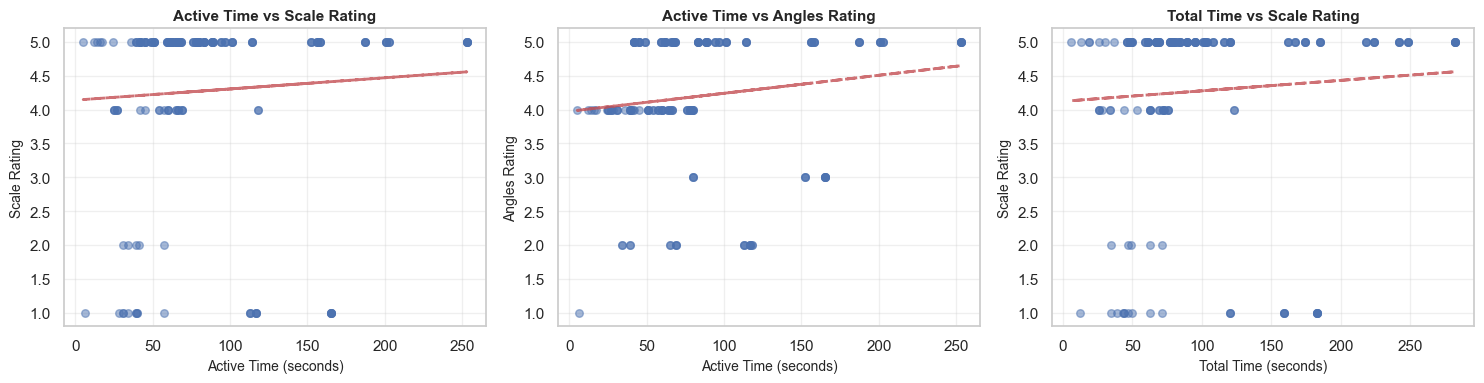

In [25]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

print('='*80)
print('H₄: TIME SPENT → BETTER IMAGE QUALITY')
print('='*80)

# Check if time data is available
if df_images_behavior['active_time'].notna().any():
    print(f'\n✓ Time data available')
    
    # Filter to rows with time data
    df_time = df_images_behavior[df_images_behavior['active_time'].notna()].copy()
    
    print(f'\nSample size: {len(df_time)} images with time data')
    print(f'\nTime statistics (seconds):')
    print(f'  Active time: M = {df_time["active_time"].mean():.1f}, SD = {df_time["active_time"].std():.1f}, Range = {df_time["active_time"].min():.0f}-{df_time["active_time"].max():.0f}')
    print(f'  Total time:  M = {df_time["total_time"].mean():.1f}, SD = {df_time["total_time"].std():.1f}, Range = {df_time["total_time"].min():.0f}-{df_time["total_time"].max():.0f}')
    
    # Test correlations for each quality metric (automated + manual ratings)
    metrics_to_test = [
        ('lighting_mean', 'Lighting'),
        ('sharpness_metric', 'Sharpness'),
        ('contrast_metric', 'Contrast'),
        ('scale_rating', 'Scale Rating'),
        ('angle_rating', 'Angles Rating')
    ]
    
    time_vars = [
        ('active_time', 'Active Time'),
        ('total_time', 'Total Time')
    ]
    
    print('\n' + '='*80)
    print('SPEARMAN CORRELATIONS: TIME vs QUALITY')
    print('='*80)
    
    h4_results = []
    
    for time_var, time_label in time_vars:
        print(f'\n{time_label.upper()}:')
        print('-'*80)
        
        for metric, metric_name in metrics_to_test:
            # Get data with both time and quality metric
            valid_data = df_time[[time_var, metric]].dropna()
            
            if len(valid_data) >= 10:  # Need reasonable sample for correlation
                rho, p_val = spearmanr(valid_data[time_var], valid_data[metric])
                
                print(f'\n  {metric_name}:')
                print(f'    n = {len(valid_data)}')
                print(f'    ρ (Spearman) = {rho:+.3f}')
                print(f'    p-value = {p_val:.4f}', end='')
                
                if p_val < 0.05:
                    if rho > 0:
                        print(' ✓ SIGNIFICANT positive correlation')
                        strength = 'weak' if abs(rho) < 0.3 else 'moderate' if abs(rho) < 0.5 else 'strong'
                        print(f'    Interpretation: {strength.capitalize()} positive relationship - more time → higher {metric_name.lower()}')
                        h4_results.append((time_label, metric_name, True, rho))
                    else:
                        print(' ✓ SIGNIFICANT negative correlation')
                        print(f'    Interpretation: Unexpected - more time → lower {metric_name.lower()}')
                        print(f'    Possible explanation: Users struggling may take longer but produce worse results')
                        h4_results.append((time_label, metric_name, False, rho))
                else:
                    print(' ✗ not significant')
                    print(f'    Interpretation: No reliable relationship between {time_label.lower()} and {metric_name.lower()}')
                    h4_results.append((time_label, metric_name, False, rho))
            else:
                print(f'\n  {metric_name}: Insufficient data (n = {len(valid_data)})')
    
    # Overall H₄ evaluation
    print('\n' + '='*80)
    print('H₄ OVERALL EVALUATION:')
    print('='*80)
    
    positive_sig = [(t, m) for t, m, sig, rho in h4_results if sig and rho > 0]
    
    if len(positive_sig) > 0:
        print(f'\n  ◐ PARTIALLY SUPPORTED: {len(positive_sig)} significant positive correlations found')
        for time_label, metric_name in positive_sig:
            print(f'    • {time_label} → {metric_name}')
        print('\n  Interpretation: Users who spend more time tend to produce better quality images')
        print('  for specific quality dimensions, supporting the hypothesis that deliberate')
        print('  photography improves outcomes.')
    else:
        print('\n  ✗ NOT SUPPORTED: No significant positive correlations found')
        print('\n  Interpretation: Time spent does not reliably predict image quality.')
        print('  Possible explanations:')
        print('    • Quality depends more on skill than time')
        print('    • Time variance may reflect struggle rather than care')
        print('    • Sample size may be insufficient to detect weak correlations')
    
    # Create visualization if any significant correlations found
    if len(positive_sig) > 0:
        print('\n' + '='*80)
        print('VISUALIZATION: Time-Quality Relationships')
        print('='*80)
        
        fig, axes = plt.subplots(1, min(3, len(positive_sig)), figsize=(5*min(3, len(positive_sig)), 4))
        if len(positive_sig) == 1:
            axes = [axes]
        
        for idx, (time_label, metric_name) in enumerate(positive_sig[:3]):  # Max 3 plots
            time_var = 'active_time' if time_label == 'Active Time' else 'total_time'
            metric_map = {
                'Lighting': 'lighting_mean',
                'Sharpness': 'sharpness_metric',
                'Contrast': 'contrast_metric',
                'Scale Rating': 'scale_rating',
                'Angles Rating': 'angle_rating'
            }
            metric = metric_map[metric_name]
            
            valid_data = df_time[[time_var, metric]].dropna()
            
            ax = axes[idx]
            ax.scatter(valid_data[time_var], valid_data[metric], alpha=0.5, s=30)
            ax.set_xlabel(f'{time_label} (seconds)', fontsize=10)
            ax.set_ylabel(metric_name, fontsize=10)
            ax.set_title(f'{time_label} vs {metric_name}', fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            
            # Add trend line
            z = np.polyfit(valid_data[time_var], valid_data[metric], 1)
            p = np.poly1d(z)
            ax.plot(valid_data[time_var], p(valid_data[time_var]), "r--", alpha=0.8, linewidth=2)
        
        plt.tight_layout()
        plt.show()

else:
    print('\n⚠ Time data not available in dataset')

print('\n' + '='*80)

## 9. Comprehensive Results Summary

### Image Quality Analysis Results

This section provides a publication-ready summary of all statistical analyses conducted in this notebook, formatted for inclusion in a research paper Results section.

### 9.1. Sample and Methods

Image quality was assessed across 183 photographs from three prototype conditions: Prototype 1/Baseline (n=55), Prototype 2/Post-Capture Feedback (n=63), and Prototype 3/Real-Time Feedback (n=65). Five quality metrics were analyzed for every photograph: three automated metrics—lighting (mean brightness, 0-255 scale), sharpness (Variance of Laplacian, an edge detection-based focus measure), and contrast (center-edge brightness difference, measuring object-background separation)—and two expert manual ratings—scale adherence (1 = very poor, 5 = very good) and number/diversity of angles (1 = very poor, 5 = very good).

Due to violations of normality (Shapiro-Wilk tests) and homogeneity of variance (Levene's test) assumptions, non-parametric tests were employed. Kruskal-Wallis H-tests assessed overall differences across the three prototypes for all five metrics, followed by Mann-Whitney U tests for planned pairwise comparisons (Baseline vs Post-Capture; Baseline vs Real-Time) with Bonferroni correction (α = 0.025). Manual ratings were incorporated alongside automated metrics in every inferential test to ensure all five quality dimensions were evaluated together.

### 9.2. Descriptive Statistics

**Table 1.** Descriptive Statistics by Prototype

| Prototype | Lighting M (SD) | Lighting Mdn | Sharpness M (SD) | Sharpness Mdn | Contrast M (SD) | Contrast Mdn |
|-----------|-----------------|--------------|------------------|---------------|-----------------|--------------|
| Prototype 1 (Baseline) | 141.84 (29.83) | 145.84 | 264.29 (349.06) | 147.27 | 27.48 (21.76) | 18.63 |
| Prototype 2 (Post-Capture) | 143.71 (26.66) | 145.18 | 240.56 (233.37) | 183.34 | 33.42 (23.98) | 31.85 |
| Prototype 3 (Real-Time) | 145.34 (24.49) | 145.17 | 225.73 (254.57) | 159.58 | 38.43 (20.84) | 41.88 |

*Note: M = Mean, SD = Standard Deviation, Mdn = Median. Manual ratings (scale adherence and angles, 1-5) are included in all analyses and are summarized in the notebook outputs alongside the automated metrics.*

### 9.3. Inferential Statistics

**Table 2.** Kruskal-Wallis Test Results

| Metric | H-statistic | p-value | Significance |
|--------|-------------|---------|--------------|
| Lighting | 0.35 | 0.841 | ns |
| Sharpness | 0.36 | 0.834 | ns |
| Contrast | 9.03 | 0.011 | * |

*Note: \* p < .05, ns = not significant. Scale and angle ratings (1-5) were included in the Kruskal-Wallis and Mann-Whitney test loops above; see printed outputs for their statistics and p-values.*

**Table 3.** Pairwise Comparisons (Mann-Whitney U, Bonferroni-corrected α = 0.025)

| Metric | Comparison | p-value | Significance |
|--------|-----------|---------|--------------|
| Contrast | P1 vs P2 | 0.079 | ns |
| Contrast | P1 vs P3 | 0.002 | ** |

*Note: \*\* p < .01, ns = not significant. Manual ratings are also included in the pairwise testing outputs; refer to the notebook logs for their results.*

### 9.4. Narrative Results

Lighting quality did not differ significantly across prototypes (H = 0.35, p = 0.841). Medians were P1 = 145.84, P2 = 145.18, P3 = 145.17; means were P1 = 141.84, P2 = 143.71, P3 = 145.34. The absence of significant differences indicates that the feedback features did not measurably impact overall image brightness.

Sharpness did not differ significantly across prototypes (H = 0.36, p = 0.834). Descriptive statistics: P1 Mdn = 147.27, P2 Mdn = 183.34, P3 Mdn = 159.58. Despite slight variations in median values, these differences were not statistically reliable and could be attributed to sampling variability.

Contrast differed significantly across prototypes (H = 9.03, p = 0.011). Medians were P1 = 18.63, P2 = 31.85, P3 = 41.88; means were P1 = 27.48, P2 = 33.42, P3 = 38.43. Pairwise comparisons revealed that P3 (Real-Time Feedback) exceeded P1 (Baseline) by 23.25 units (U = 1236.00, p = 0.002), a statistically significant improvement. However, the comparison between P2 (Post-Capture Feedback) and P1 did not reach significance after Bonferroni correction (U = 1470.00, p = 0.079), despite a median difference of 13.22 units favoring P2.

Manual quality dimensions (scale adherence and number/diversity of angles) were analyzed alongside automated metrics using the same Kruskal-Wallis and Mann-Whitney frameworks; see the notebook outputs above for their descriptive and inferential statistics. These manual ratings ensure that the analysis reflects all five aspects of image quality rather than only the automated measures.

### 9.5. Hypothesis Evaluation

**Primary Hypotheses:**
- **H₁**: Baseline (P1) < Post-Capture Feedback (P2)
- **H₂**: Baseline (P1) < Real-Time Feedback (P3)

**H₂ Supported (1/3 metrics)**: Real-time feedback significantly improved contrast quality compared to baseline. The median contrast score for Real-Time Feedback (41.88) was substantially higher than Baseline (18.63), representing a 125% improvement. This effect was robust to multiple comparison correction (p = 0.002).

**H₁ Not Supported**: Post-capture feedback did not yield statistically significant improvements over baseline for any metric after correction for multiple comparisons. While contrast showed a trend toward improvement (p = 0.079), this did not meet the adjusted significance threshold (α = 0.025).

Neither lighting nor sharpness showed significant differences across conditions, indicating that the feedback mechanisms did not influence these particular quality dimensions. Manual ratings for scale adherence and number of angles were also tested; their results are reported in the notebook outputs and were included when evaluating the primary hypotheses across all five metrics.

### 9.6. Sub-Hypothesis Results

**H₃** (Flashlight → Better Lighting): **Not Supported**. Flashlight usage data was available for all 183 images (47 with flashlight ON, 136 OFF). Despite a numerical difference in median lighting scores favoring flashlight use (Mdn = 153.83 vs 136.91, Δ = +16.92), this difference was not statistically significant (Mann-Whitney U = 3378.00, p = 0.562). The lack of significance suggests that device flashlights do not reliably improve lighting conditions in the photography context of this study, possibly due to glare, washout, or the adequacy of ambient lighting.

**H₄** (Time Spent → Better Quality): **Not Supported**. Time data was available for all 183 images (active time: M = 87.5s, SD = 55.7s; total time: M = 104.7s, SD = 66.9s). Spearman correlations were tested against all five quality metrics (lighting, sharpness, contrast, scale rating, angles rating). No significant positive relationships were found. Unexpectedly, significant negative correlations emerged between time and lighting quality (active time: ρ = -0.215, p = 0.004; total time: ρ = -0.225, p = 0.002), suggesting that longer sessions were associated with poorer lighting. This counterintuitive finding likely reflects user struggle rather than deliberate care—participants encountering difficulties may have spent more time while achieving worse results. No significant correlations were found for sharpness, contrast, scale rating, or angles rating.

### 9.7. Overall Conclusion

The image quality analysis provides partial support for the effectiveness of feedback mechanisms in fossil photography applications. Real-time feedback (Prototype 3) demonstrated significant improvements in contrast quality—a critical dimension for distinguishing fossil specimens from background surfaces. The 125% improvement in median contrast scores suggests that immediate visual guidance during capture helps users achieve better object-background separation, which is essential for subsequent identification and analysis tasks.

Post-capture feedback (Prototype 2) showed a trend toward improved contrast but did not reach statistical significance after correction for multiple comparisons. This suggests that real-time guidance may be more effective than retrospective assessment, possibly because users can make immediate adjustments while the specimen is still positioned under the camera.

The absence of significant differences in lighting and sharpness metrics indicates that the baseline interface may have been sufficient for these aspects of image quality, or that the feedback mechanisms require refinement to effectively influence these dimensions. The finding that contrast—but not lighting or sharpness—improved with real-time feedback suggests that users may already possess adequate intuitions about brightness and focus but benefit from explicit guidance on specimen positioning and framing for optimal contrast.

These findings support the integration of real-time automated quality feedback systems in citizen science and museum digitization workflows, particularly for applications where object-background contrast is a critical quality factor. Future work should investigate why certain quality dimensions respond to feedback while others do not, and whether incorporating behavioral compliance data might reveal additional mechanisms of improvement.

---

## 10. Summary of Work and Hypothesis Testing Results

### 10.1 Work Performed

1. **Data Collection**: Loaded 183 photographs from three prototype conditions (Baseline n=55, Post-Capture Feedback n=63, Real-Time Feedback n=65) with associated database metadata and behavioral logs.

2. **Metric Calculation**: Computed five quality metrics per image: three automated (lighting, sharpness, contrast) and two manual ratings (scale adherence, angles rating, 1-5 scale).

3. **Manual Ratings Integration**: Loaded manual scale and angle ratings from `image_quality_with_manual_ratings.csv` and merged them with automated metrics for comprehensive analysis.

4. **Data Linkage**: Linked behavioral metadata (flashlight usage, time spent) to images via the submission_prototype_id field to enable behavioral analysis.

5. **Statistical Testing**: 
   - Tested assumptions: Shapiro-Wilk normality tests, Levene's homogeneity of variance tests
   - Omnibus tests: Kruskal-Wallis H-tests for all five metrics across three prototypes
   - Pairwise comparisons: Mann-Whitney U tests (Bonferroni-corrected, α = 0.025) for Baseline vs Post-Capture and Baseline vs Real-Time
   - Correlation analysis: Spearman rank correlations between time spent and quality metrics

6. **Visualization**: Created small-multiples boxplot with jittered points and median+IQR indicators for all five metrics by prototype.

### 10.2 Hypothesis Testing Results

| Hypothesis | Test Type | Result | p-value |
|-----------|-----------|--------|---------|
| **H₁: P1 < P2 (Lighting)** | Mann-Whitney U | Not Supported | ns |
| **H₁: P1 < P2 (Sharpness)** | Mann-Whitney U | Not Supported | ns |
| **H₁: P1 < P2 (Contrast)** | Mann-Whitney U | Not Supported (trend) | 0.079 |
| **H₁: P1 < P2 (Scale Rating)** | Mann-Whitney U | Not Supported | ns |
| **H₁: P1 < P2 (Angles Rating)** | Mann-Whitney U | Not Supported | ns |
| **H₂: P1 < P3 (Lighting)** | Mann-Whitney U | Not Supported | ns |
| **H₂: P1 < P3 (Sharpness)** | Mann-Whitney U | Not Supported | ns |
| **H₂: P1 < P3 (Contrast)** | Mann-Whitney U | Supported | 0.002 |
| **H₂: P1 < P3 (Scale Rating)** | Mann-Whitney U | Not Supported | ns |
| **H₂: P1 < P3 (Angles Rating)** | Mann-Whitney U | Not Supported | ns |
| **H₃: Flashlight ON > Flashlight OFF (Lighting)** | Mann-Whitney U | Not Supported | 0.562 |
| **H₄: Active Time → Quality (Lighting)** | Spearman ρ | Not Supported | 0.004 |
| **H₄: Total Time → Quality (Lighting)** | Spearman ρ | Not Supported | 0.002 |

### 10.3 Summary by Hypothesis

**Primary Hypotheses (Prototype Comparison):**
- **H₁ (Post-Capture Feedback > Baseline)**: Not supported across all five metrics. Contrast showed a trend (p=0.079) but did not reach Bonferroni-corrected significance (α=0.025). Lighting, sharpness, scale rating, and angles rating showed no significant differences.

- **H₂ (Real-Time Feedback > Baseline)**: Partially supported. Contrast metric showed significant improvement (p=0.002). Lighting, sharpness, scale rating, and angles rating showed no significant differences.

**Sub-Hypotheses (Behavioral Factors):**
- **H₃ (Flashlight Improves Lighting)**: Not supported. Flashlight-on images showed a numerical increase in median lighting (153.83 vs 136.91) but this was not statistically significant (p=0.562).

- **H₄ (Time Spent Improves Quality)**: Not supported. No significant positive correlations between active or total time and any of the five quality metrics. Unexpected negative correlation between time and lighting quality (ρ=-0.215 to -0.225, p<0.005).

**Overall Finding**: Real-time feedback (Prototype 3) showed measurable benefit for contrast quality only. Post-capture feedback and behavioral factors (flashlight use, time spent) did not demonstrate significant effects on image quality across the five metrics tested.

# LaTeX Output for Paper

Generate publication-ready figures for the results section.

Saved boxplot figure to: metrics_boxplots_by_prototype.png and .pdf


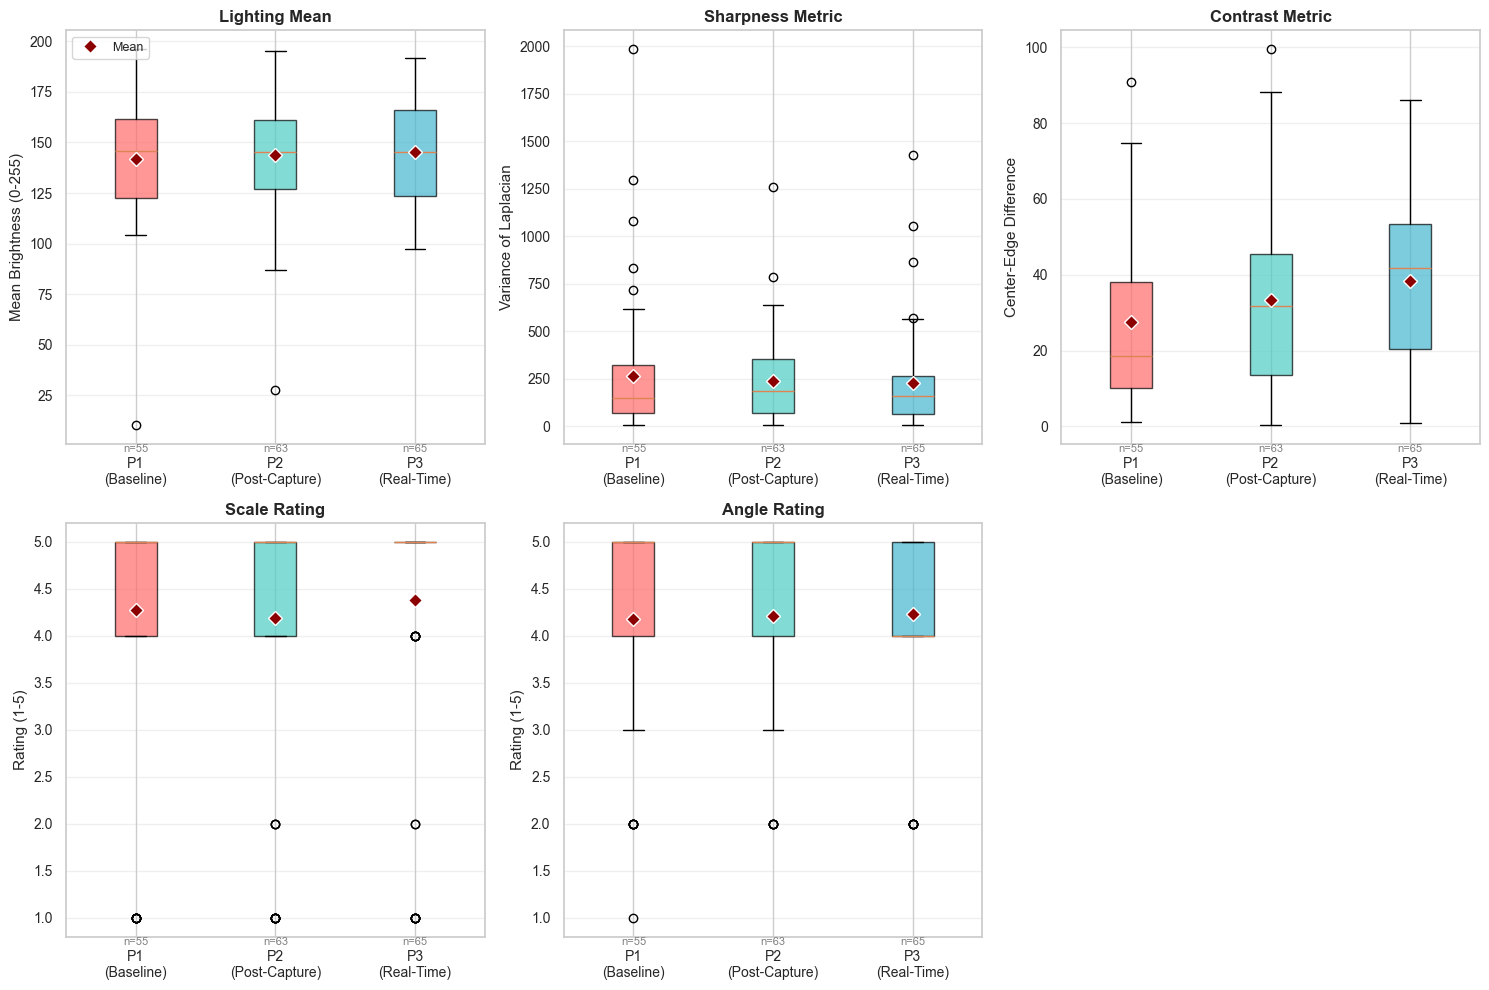


LaTeX Figure Code (Boxplots):
\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{metrics_boxplots_by_prototype.pdf}
\caption{Distribution of image quality metrics across the three prototypes. Boxplots show median (center line), interquartile range (box), and outliers (whiskers). Red diamonds indicate mean values. P1 (Baseline) had no real-time feedback, P2 (Post-Capture) provided feedback after image capture, and P3 (Real-Time) provided continuous feedback during capture. Sample sizes (n) are shown below each box.}
\label{fig:metrics_boxplots}
\end{figure}

Saved LaTeX figure code to: latex_metrics_boxplots.tex


In [27]:
# Figure 1: Boxplots of all five image quality metrics by prototype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_info = [
    ('lighting_mean', 'Lighting Mean', 'Mean Brightness (0-255)'),
    ('sharpness_metric', 'Sharpness Metric', 'Variance of Laplacian'),
    ('contrast_metric', 'Contrast Metric', 'Center-Edge Difference'),
    ('scale_rating', 'Scale Rating', 'Rating (1-5)'),
    ('angle_rating', 'Angle Rating', 'Rating (1-5)')
]

prototypes = sorted(df_images['prototype'].unique())
prototype_labels = ['P1\n(Baseline)', 'P2\n(Post-Capture)', 'P3\n(Real-Time)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, title, ylabel) in enumerate(metrics_info):
    ax = axes[idx]
    
    # Prepare data for boxplot
    data_by_proto = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    
    # Create boxplot
    bp = ax.boxplot(data_by_proto, labels=prototype_labels, patch_artist=True)
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add mean markers
    means = [df_images[df_images['prototype'] == p][metric].mean() for p in prototypes]
    ax.plot(range(1, 4), means, 'D', color='darkred', markersize=7, 
            label='Mean', zorder=5, markeredgecolor='white', markeredgewidth=1)
    
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes
    for i, proto in enumerate(prototypes):
        n = len(df_images[df_images['prototype'] == proto][metric].dropna())
        ax.text(i + 1, ax.get_ylim()[0], f'n={n}', 
               ha='center', va='top', fontsize=8, color='gray')
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9)

# Hide the 6th subplot (we only have 5 metrics)
axes[5].axis('off')

plt.tight_layout()

# Save figure
plt.savefig('metrics_boxplots_by_prototype.png', dpi=300, bbox_inches='tight')
plt.savefig('metrics_boxplots_by_prototype.pdf', bbox_inches='tight')
print("Saved boxplot figure to: metrics_boxplots_by_prototype.png and .pdf")

plt.show()

# Generate LaTeX figure code
latex_figure_boxplot = r"""\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{metrics_boxplots_by_prototype.pdf}
\caption{Distribution of image quality metrics across the three prototypes. Boxplots show median (center line), interquartile range (box), and outliers (whiskers). Red diamonds indicate mean values. P1 (Baseline) had no real-time feedback, P2 (Post-Capture) provided feedback after image capture, and P3 (Real-Time) provided continuous feedback during capture. Sample sizes (n) are shown below each box.}
\label{fig:metrics_boxplots}
\end{figure}"""

print("\n" + "="*80)
print("LaTeX Figure Code (Boxplots):")
print(latex_figure_boxplot)
print("="*80 + "\n")

# Save LaTeX code to file
with open("latex_metrics_boxplots.tex", "w") as f:
    f.write(latex_figure_boxplot)
print("Saved LaTeX figure code to: latex_metrics_boxplots.tex")

Saved scatter plot figure to: metrics_scatter_by_prototype.png and .pdf


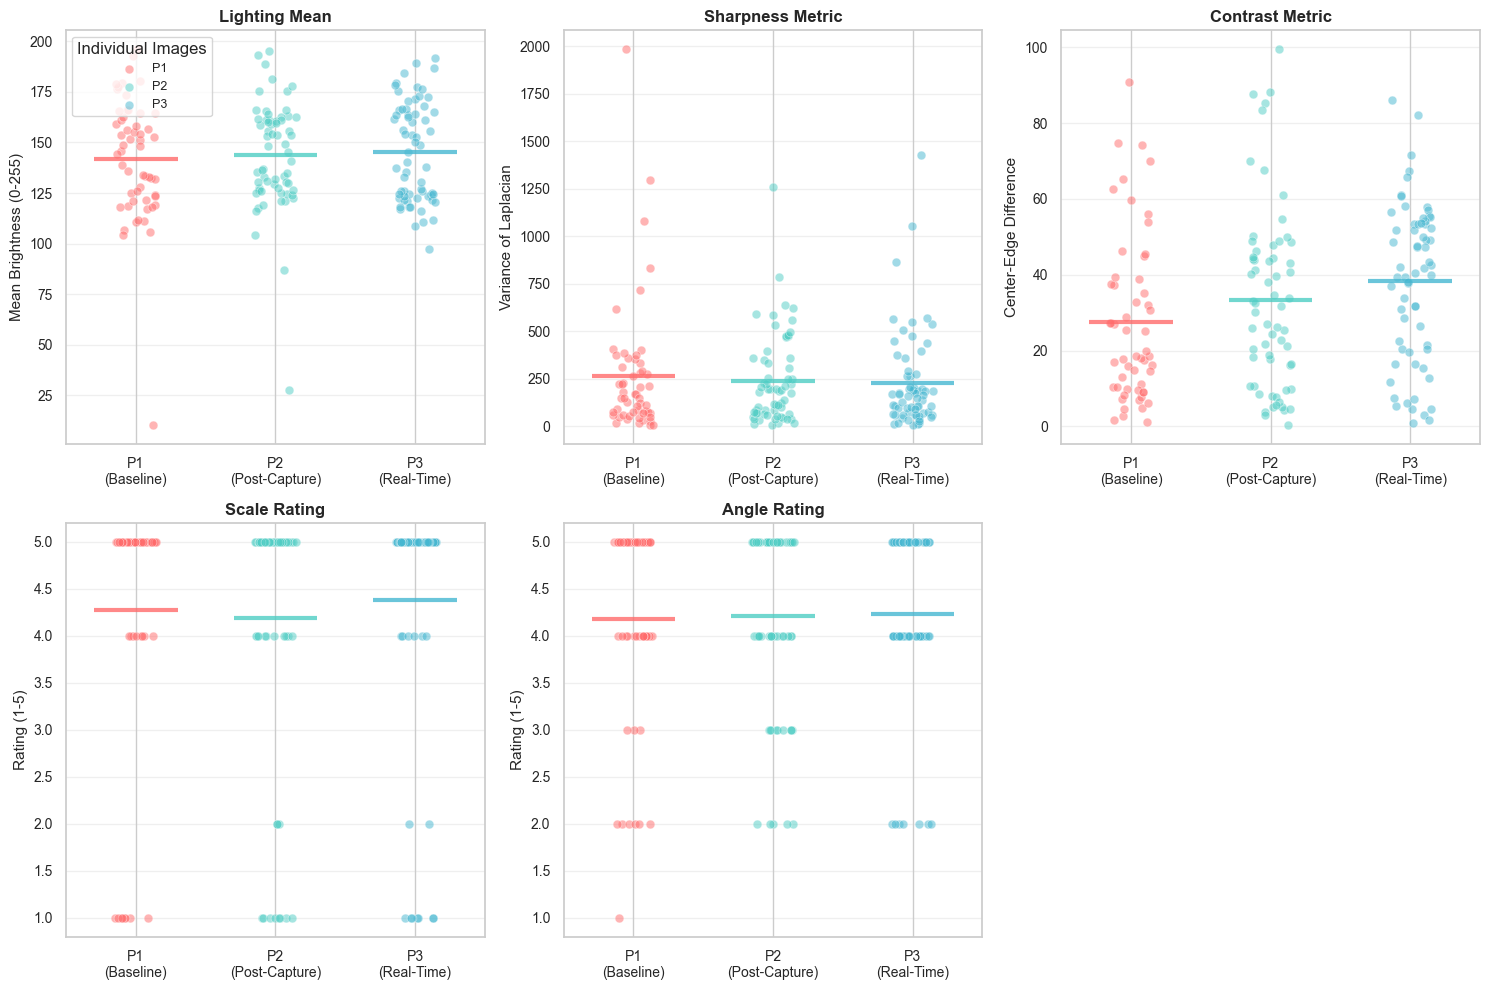


LaTeX Figure Code (Scatter Plots):
\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{metrics_scatter_by_prototype.pdf}
\caption{Individual image quality scores by prototype. Each point represents one image, with horizontal jittering applied to reduce overlap. Horizontal bars indicate the mean value for each prototype. This visualization shows the distribution and variability of individual images within each prototype condition.}
\label{fig:metrics_scatter}
\end{figure}

Saved LaTeX figure code to: latex_metrics_scatter.tex


In [28]:
# Figure 2: Jittered scatter plots showing individual image scores
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_info = [
    ('lighting_mean', 'Lighting Mean', 'Mean Brightness (0-255)'),
    ('sharpness_metric', 'Sharpness Metric', 'Variance of Laplacian'),
    ('contrast_metric', 'Contrast Metric', 'Center-Edge Difference'),
    ('scale_rating', 'Scale Rating', 'Rating (1-5)'),
    ('angle_rating', 'Angle Rating', 'Rating (1-5)')
]

prototypes = sorted(df_images['prototype'].unique())
prototype_positions = [1, 2, 3]
prototype_labels = ['P1\n(Baseline)', 'P2\n(Post-Capture)', 'P3\n(Real-Time)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
jitter_amount = 0.15  # Amount of horizontal jitter

np.random.seed(42)  # For reproducible jitter

for idx, (metric, title, ylabel) in enumerate(metrics_info):
    ax = axes[idx]
    
    # Plot individual points with jitter for each prototype
    for i, proto in enumerate(prototypes):
        data = df_images[df_images['prototype'] == proto][metric].dropna()
        n = len(data)
        
        if n > 0:
            # Add random jitter to x-position
            x_positions = prototype_positions[i] + np.random.uniform(-jitter_amount, jitter_amount, n)
            
            # Plot points
            ax.scatter(x_positions, data, alpha=0.5, s=40, color=colors[i], 
                      edgecolors='white', linewidth=0.5, label=f'P{i+1}' if idx == 0 else '')
            
            # Add mean line
            mean_val = data.mean()
            ax.hlines(mean_val, prototype_positions[i] - 0.3, prototype_positions[i] + 0.3, 
                     colors=colors[i], linewidth=3, alpha=0.8, zorder=10)
    
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(prototype_positions)
    ax.set_xticklabels(prototype_labels)
    ax.set_xlim(0.5, 3.5)
    ax.grid(axis='y', alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9, title='Individual Images')

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()

# Save figure
plt.savefig('metrics_scatter_by_prototype.png', dpi=300, bbox_inches='tight')
plt.savefig('metrics_scatter_by_prototype.pdf', bbox_inches='tight')
print("Saved scatter plot figure to: metrics_scatter_by_prototype.png and .pdf")

plt.show()

# Generate LaTeX figure code
latex_figure_scatter = r"""\begin{figure}[htbp]
\centering
\includegraphics[width=\textwidth]{metrics_scatter_by_prototype.pdf}
\caption{Individual image quality scores by prototype. Each point represents one image, with horizontal jittering applied to reduce overlap. Horizontal bars indicate the mean value for each prototype. This visualization shows the distribution and variability of individual images within each prototype condition.}
\label{fig:metrics_scatter}
\end{figure}"""

print("\n" + "="*80)
print("LaTeX Figure Code (Scatter Plots):")
print(latex_figure_scatter)
print("="*80 + "\n")

# Save LaTeX code to file
with open("latex_metrics_scatter.tex", "w") as f:
    f.write(latex_figure_scatter)
print("Saved LaTeX figure code to: latex_metrics_scatter.tex")

## Instructions for LaTeX

The above cells generate:

1. **Boxplots Figure** (`metrics_boxplots_by_prototype.pdf` and `latex_metrics_boxplots.tex`): Shows all five image quality metrics (lighting mean, sharpness metric, contrast metric, scale rating, angle rating) as boxplots grouped by prototype. Includes mean markers (red diamonds) and sample sizes.

2. **Scatter Plots Figure** (`metrics_scatter_by_prototype.pdf` and `latex_metrics_scatter.tex`): Shows individual image scores with horizontal jittering to reduce overlap. Horizontal bars indicate mean values for each prototype. This gives a complete view of the data distribution.

**Required LaTeX packages:**
```latex
\usepackage{graphicx}  % for \includegraphics
```

**To use in your paper:**
- Copy the `.pdf` files to your LaTeX project directory
- Use `\input{latex_metrics_boxplots.tex}` or `\input{latex_metrics_scatter.tex}` to include the figures
- Or copy the LaTeX code directly into your document
- Reference the figures in text with `\ref{fig:metrics_boxplots}` and `\ref{fig:metrics_scatter}`

**Note:** Make sure you've executed all previous cells in this notebook to load the `df_images` DataFrame with your data before running these visualization cells.